# 从文本提取信息

本章的目的是要回答下列问题：
1. 我们如何能构建一个系统，从非结构化文本中提取结构化数据？
2. 有哪些稳健的方法识别一个文本中描述的实体和关系？
3. 哪些语料库适合这项工作，我们如何使用它们来训练和评估我们的模型？
一路上，我们将应用最后两章中的技术来解决分块和命名实体识别

## 信息提取
与表 7.1 不同，（1）不包含连结组织名和位置名的结构。

这个问题的解决方法之一是建立一个非常通用的意义重现（第 10 章）。在这一章中，我

们采取不同的方法，提前定为我们将只查找文本中非常具体的各种信息，如：组织和地点之

间的关系。不是试图用文字像（1）那样直接回答这个问题，我们首先将自然语言句子这样

的非结构化数据转换成表 7-1 的结构化数据。然后，利用强大的查询工具，如 SQL。这种从

文本获取意义的方法被称为信息提取


要执行前面三项任务，我们可以定义一个函数，简单地连接 NLTK 中默认的句子分割
器�，分词器�和词性标注器�：

In [1]:
def ie_preprocess(document):
    sentences = nltk.sent_tokenize(document)
    sentences = [nltk.word_tokenize(sent) for sent in sentences]
    sentences = [nltk.pos_tag(sent) for sent in sentences]

接下来，命名实体识别中，我们分割和标注可能组成一个有趣关系的实体。

## 词块划分
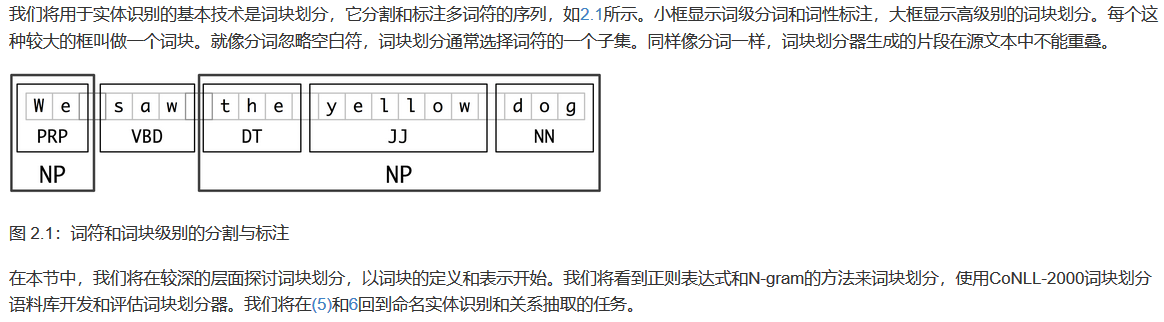

In [2]:
import nltk
import re
import pprint

In [6]:
#2.1 名词短语词块划分
'''
其中的NP词块用方括号标记!!!
基本的分块：组块 :{组块下的子组块}（类似于："NP: {<DT>?<JJ>*<NN>}"这样的字符串）。
而?*+保存了正则表达式的意义。
'''
sentence = [('the','DT'),('little','JJ'),('yellow','JJ'),('dog','NN'),('brak','VBD')
           , ("at", "IN"),  ("the", "DT"), ("cat", "NN")]
grammer = "NP: {<DT>?<JJ>*<NN>}"
cp = nltk.RegexpParser(grammer) #生成规则
result = cp.parse(sentence) #进行分块
print(result)

(S
  (NP the/DT little/JJ yellow/JJ dog/NN)
  brak/VBD
  at/IN
  (NP the/DT cat/NN))


In [5]:
result.draw()

In [9]:
#2.2 标记模式
'''
思考如下短语：
another/DT sharp/JJ dive/NN
trade/NN figures/NNS
any/DT new/JJ policy/NN measures/NNS
earlier/JJR stages/NNS
Panamanian/JJ dictator/NN Manuel/NNP Noriega/NNP
'''
print '''
我们可以使用轻微改进的上述第一个标记模式来匹配这些名词短语，如<DT>?<JJ.*
>*<NN.*>+。这将把任何以一个可选的限定词开头，后面跟零个或多个任何类型的形容
词（包括相对形容词，如 earlier/JJR），后面跟一个或多个任何类型的名词的标识符序列分
块。
'''


我们可以使用轻微改进的上述第一个标记模式来匹配这些名词短语，如<DT>?<JJ.*
>*<NN.*>+。这将把任何以一个可选的限定词开头，后面跟零个或多个任何类型的形容
词（包括相对形容词，如 earlier/JJR），后面跟一个或多个任何类型的名词的标识符序列分
块。



In [27]:
#2.3 用正则表达式进行词块划分
'''
要找到一个给定的句子的词块结构，RegexpParser词块划分器以一个没有词符被划分的平面结构开始。
词块划分规则轮流应用，依次更新词块结构。一旦所有的规则都被调用，返回生成的词块结构。

第一条规则匹配一个可选的限定词或所有格代名词，零个或多个形容词，然后跟一个名词
第二条规则匹配一个或多个专有名词
'''
grammar = r"""
  NP: {<DT|PP\$>?<JJ>*<NN>+}   # chunk determiner/possessive, adjectives and noun
      {<NNP>+}                # chunk sequences of proper nouns
"""
cp = nltk.RegexpParser(grammar)
sentence = [("Rapunzel", "NNP"), ("let", "VBD"), ("down", "RP"), 
                 ("her", "PP$"), ("long", "JJ"), ("golden", "JJ"), ("hair", "NN")]

In [28]:
print cp.parse(sentence)

(S
  (NP Rapunzel/NNP)
  let/VBD
  down/RP
  (NP her/PP$ long/JJ golden/JJ hair/NN))


In [13]:
# $符号是正则表达式中的一个特殊字符，必须使用转义符\来匹配 PP$标记。

In [29]:
#2.4 探索文本语料库
cp = nltk.RegexpParser('CHUNK: {<V.*> <TO> <V.*>}')
brown = nltk.corpus.brown
for sent in brown.tagged_sents():
    tree = cp.parse(sent)
    for subtree in tree.subtrees():
        if subtree.label() == 'CHUNK': print(subtree)

(CHUNK combined/VBN to/TO achieve/VB)
(CHUNK continue/VB to/TO place/VB)
(CHUNK serve/VB to/TO protect/VB)
(CHUNK wanted/VBD to/TO wait/VB)
(CHUNK allowed/VBN to/TO place/VB)
(CHUNK expected/VBN to/TO become/VB)
(CHUNK expected/VBN to/TO approve/VB)
(CHUNK expected/VBN to/TO make/VB)
(CHUNK intends/VBZ to/TO make/VB)
(CHUNK seek/VB to/TO set/VB)
(CHUNK like/VB to/TO see/VB)
(CHUNK designed/VBN to/TO provide/VB)
(CHUNK get/VB to/TO hear/VB)
(CHUNK expects/VBZ to/TO tell/VB)
(CHUNK expected/VBN to/TO give/VB)
(CHUNK prefer/VB to/TO pay/VB)
(CHUNK required/VBN to/TO obtain/VB)
(CHUNK permitted/VBN to/TO teach/VB)
(CHUNK designed/VBN to/TO reduce/VB)
(CHUNK Asked/VBN to/TO elaborate/VB)
(CHUNK got/VBN to/TO go/VB)
(CHUNK raised/VBN to/TO pay/VB)
(CHUNK scheduled/VBN to/TO go/VB)
(CHUNK cut/VBN to/TO meet/VB)
(CHUNK needed/VBN to/TO meet/VB)
(CHUNK hastened/VBD to/TO add/VB)
(CHUNK found/VBN to/TO prevent/VB)
(CHUNK continue/VB to/TO insist/VB)
(CHUNK compelled/VBN to/TO make/VB)
(CHUNK mad

(CHUNK needed/VBN to/TO push/VB)
(CHUNK trying/VBG to/TO get/VB)
(CHUNK try/VB to/TO get/VB)
(CHUNK want/VB to/TO increase/VB)
(CHUNK wants/VBZ to/TO bring/VB)
(CHUNK threaten/VB to/TO strike/VB)
(CHUNK begun/VBN to/TO grow/VB)
(CHUNK combine/VB to/TO serve/VB)
(CHUNK helping/VBG to/TO strengthen/VB)
(CHUNK designed/VBN to/TO promote/VB)
(CHUNK threatening/VBG to/TO expand/VB)
(CHUNK seeks/VBZ to/TO get/VB)
(CHUNK begin/VB to/TO see/VB)
(CHUNK continue/VB to/TO expand/VB)
(CHUNK failing/VBG to/TO render/VB)
(CHUNK decided/VBD to/TO tackle/VB)
(CHUNK expects/VBZ to/TO sign/VB)
(CHUNK tends/VBZ to/TO become/VB)
(CHUNK came/VBD to/TO understand/VB)
(CHUNK deserve/VB to/TO breathe/VB)
(CHUNK advised/VBN to/TO seek/VB)
(CHUNK attempting/VBG to/TO make/VB)
(CHUNK try/VB to/TO gun/VB)
(CHUNK began/VBD to/TO fill/VB)
(CHUNK proposes/VBZ to/TO preserve/VB)
(CHUNK asked/VBN to/TO approve/VB)
(CHUNK seeking/VBG to/TO break/VB)
(CHUNK tends/VBZ to/TO spread/VB)
(CHUNK want/VB to/TO amend/VB)
(CHUN

(CHUNK seem/VB to/TO lend/VB)
(CHUNK allowed/VBN to/TO mix/VB)
(CHUNK starts/VBZ to/TO swing/VB)
(CHUNK seems/VBZ to/TO stop/VB)
(CHUNK ordered/VBN to/TO hold/VB)
(CHUNK fitted/VBN to/TO endure/VB)
(CHUNK trying/VBG to/TO follow/VB)
(CHUNK threatening/VBG to/TO explode/VB)
(CHUNK rides/VBZ to/TO break/VB)
(CHUNK managed/VBD to/TO make/VB)
(CHUNK dancing/VBG to/TO display/VB)
(CHUNK hasten/VB to/TO report/VB)
(CHUNK seems/VBZ to/TO come/VB)
(CHUNK reassuring/VBG to/TO see/VB)
(CHUNK profess/VB to/TO know/VB)
(CHUNK help/VB to/TO explain/VB)
(CHUNK forced/VBN to/TO rely/VB)
(CHUNK attempt/VB to/TO homogenize/VB)
(CHUNK like/VB to/TO put/VB)
(CHUNK continue/VB to/TO try/VB)
(CHUNK seem/VB to/TO deal/VB)
(CHUNK decide/VB to/TO let/VB)
(CHUNK tries/VBZ to/TO take/VB)
(CHUNK trying/VBG to/TO forget/VB)
(CHUNK trying/VBG to/TO acquire/VB)
(CHUNK threatens/VBZ to/TO linger/VB)
(CHUNK decided/VBN to/TO forego/VB)
(CHUNK managed/VBN to/TO hold/VB)
(CHUNK intended/VBN to/TO illustrate/VB)
(CHUNK 

(CHUNK used/VBD to/TO say/VB)
(CHUNK preferred/VBD to/TO get/VB)
(CHUNK hope/VB to/TO cover/VB)
(CHUNK want/VB to/TO miss/VB)
(CHUNK scheduled/VBN to/TO vanish/VB)
(CHUNK continued/VBD to/TO live/VB)
(CHUNK seem/VB to/TO cascade/VB)
(CHUNK forget/VB to/TO buy/VB)
(CHUNK fail/VB to/TO shorten/VB)
(CHUNK intend/VB to/TO cook/VB)
(CHUNK sized/VBN to/TO fit/VB)
(CHUNK continue/VB to/TO release/VB)
(CHUNK wish/VB to/TO create/VB)
(CHUNK trim/VB to/TO fit/VB)
(CHUNK cut/VBN to/TO fit/VB)
(CHUNK help/VB to/TO prevent/VB)
(CHUNK designed/VBN to/TO take/VB)
(CHUNK used/VBN to/TO transport/VB)
(CHUNK want/VB to/TO buy/VB)
(CHUNK used/VBN to/TO fasten/VB)
(CHUNK help/VB to/TO keep/VB)
(CHUNK needed/VBN to/TO build/VB)
(CHUNK designed/VBN to/TO accommodate/VB)
(CHUNK adjusted/VBN to/TO suit/VB)
(CHUNK used/VBN to/TO cut/VB)
(CHUNK want/VB to/TO avoid/VB)
(CHUNK agreed/VBN to/TO take/VB)
(CHUNK planned/VBD to/TO destroy/VB)
(CHUNK allowed/VBN to/TO issue/VB)
(CHUNK managed/VBD to/TO coerce/VB)
(CHU

(CHUNK liked/VBD to/TO tease/VB)
(CHUNK going/VBG to/TO buy/VB)
(CHUNK com/VB to/TO sea/VB)
(CHUNK drilled/VBN to/TO follow/VB)
(CHUNK born/VBN to/TO command/VB)
(CHUNK come/VBN to/TO recognize/VB)
(CHUNK allowed/VBN to/TO account/VB)
(CHUNK created/VBN to/TO fan/VB)
(CHUNK come/VBN to/TO mean/VB)
(CHUNK trying/VBG to/TO make/VB)
(CHUNK refusing/VBG to/TO keep/VB)
(CHUNK wishes/VBZ to/TO discuss/VB)
(CHUNK want/VB to/TO ask/VB)
(CHUNK want/VB to/TO tap/VB)
(CHUNK said/VBN to/TO use/VB)
(CHUNK employed/VBN to/TO see/VB)
(CHUNK shoot/VB to/TO kill/VB)
(CHUNK refused/VBD to/TO touch/VB)
(CHUNK threatened/VBD to/TO shoot/VB)
(CHUNK said/VBD to/TO let/VB)
(CHUNK begin/VB to/TO roll/VB)
(CHUNK held/VBN to/TO assure/VB)
(CHUNK going/VBG to/TO make/VB)
(CHUNK managed/VBD to/TO get/VB)
(CHUNK wanted/VBD to/TO play/VB)
(CHUNK prepared/VBD to/TO counterattack/VB)
(CHUNK failed/VBN to/TO rally/VB)
(CHUNK tried/VBD to/TO rape/VB)
(CHUNK refused/VBD to/TO speak/VB)
(CHUNK called/VBN to/TO look/VB)
(

(CHUNK began/VBD to/TO move/VB)
(CHUNK run/VB to/TO live/VB)
(CHUNK started/VBD to/TO glance/VB)
(CHUNK try/VB to/TO memorize/VB)
(CHUNK turned/VBD to/TO look/VB)
(CHUNK trying/VBG to/TO talk/VB)
(CHUNK started/VBD to/TO decline/VB)
(CHUNK continues/VBZ to/TO take/VB)
(CHUNK continues/VBZ to/TO center/VB)
(CHUNK come/VBN to/TO see/VB)
(CHUNK come/VB to/TO walk/VB)
(CHUNK beginning/VBG to/TO complain/VB)
(CHUNK gather/VB to/TO sing/VB)
(CHUNK began/VBD to/TO converse/VB)
(CHUNK began/VBD to/TO relax/VB)
(CHUNK hoped/VBN to/TO become/VB)
(CHUNK forced/VBN to/TO restrict/VB)
(CHUNK began/VBD to/TO give/VB)
(CHUNK asked/VBN to/TO become/VB)
(CHUNK trying/VBG to/TO sell/VB)
(CHUNK serves/VBZ to/TO stimulate/VB)
(CHUNK seemed/VBD to/TO lack/VB)
(CHUNK offered/VBD to/TO make/VB)
(CHUNK assembled/VBN to/TO warrant/VB)
(CHUNK returned/VBD to/TO preside/VB)
(CHUNK sought/VBD to/TO prevent/VB)
(CHUNK expect/VB to/TO stand/VB)
(CHUNK compelled/VBN to/TO face/VB)
(CHUNK continue/VB to/TO live/VB)
(

(CHUNK tried/VBD to/TO block/VB)
(CHUNK chosen/VBN to/TO edit/VB)
(CHUNK plotted/VBD to/TO take/VB)
(CHUNK tried/VBD to/TO halt/VB)
(CHUNK wanted/VBD to/TO die/VB)
(CHUNK returned/VBD to/TO make/VB)
(CHUNK like/VB to/TO believe/VB)
(CHUNK bother/VB to/TO look/VB)
(CHUNK used/VBD to/TO go/VB)
(CHUNK seemed/VBD to/TO thaw/VB)
(CHUNK came/VBD to/TO give/VB)
(CHUNK wanted/VBD to/TO see/VB)
(CHUNK used/VBD to/TO look/VB)
(CHUNK meant/VBN to/TO help/VB)
(CHUNK like/VB to/TO straighten/VB)
(CHUNK hope/VB to/TO give/VB)
(CHUNK bark/VB to/TO let/VB)
(CHUNK dash/VB to/TO get/VB)
(CHUNK tried/VBD to/TO talk/VB)
(CHUNK decided/VBD to/TO leave/VB)
(CHUNK used/VBD to/TO tell/VB)
(CHUNK continue/VB to/TO reflect/VB)
(CHUNK appear/VB to/TO preach/VB)
(CHUNK intend/VB to/TO let/VB)
(CHUNK need/VB to/TO test/VB)
(CHUNK learned/VBD to/TO meet/VB)
(CHUNK said/VBN to/TO give/VB)
(CHUNK serves/VBZ to/TO reduce/VB)
(CHUNK thought/VBN to/TO provide/VB)
(CHUNK tends/VBZ to/TO give/VB)
(CHUNK wish/VB to/TO deny

(CHUNK established/VBN to/TO provide/VB)
(CHUNK desire/VB to/TO explore/VB)
(CHUNK required/VBN to/TO own/VB)
(CHUNK required/VBN to/TO attain/VB)
(CHUNK decide/VB to/TO support/VB)
(CHUNK prepared/VBN to/TO depart/VB)
(CHUNK designed/VBN to/TO provide/VB)
(CHUNK designed/VBN to/TO raise/VB)
(CHUNK designed/VBN to/TO prevent/VB)
(CHUNK aimed/VBN to/TO attract/VB)
(CHUNK like/VB to/TO press/VB)
(CHUNK take/VB to/TO show/VB)
(CHUNK designed/VBN to/TO prevent/VB)
(CHUNK persuaded/VBN to/TO take/VB)
(CHUNK induced/VBN to/TO establish/VB)
(CHUNK persuaded/VBN to/TO adopt/VB)
(CHUNK persuaded/VBN to/TO adopt/VB)
(CHUNK prepared/VBN to/TO give/VB)
(CHUNK prepared/VBN to/TO enter/VB)
(CHUNK dedicated/VBN to/TO secure/VB)
(CHUNK like/VB to/TO think/VB)
(CHUNK like/VB to/TO think/VB)
(CHUNK afford/VB to/TO lose/VB)
(CHUNK continues/VBZ to/TO add/VB)
(CHUNK helping/VBG to/TO pilot/VB)
(CHUNK prefer/VB to/TO speak/VB)
(CHUNK go/VB to/TO discuss/VB)
(CHUNK made/VBN to/TO replace/VB)
(CHUNK continui

(CHUNK allowed/VBN to/TO stand/VB)
(CHUNK allowed/VBN to/TO stand/VB)
(CHUNK used/VBN to/TO test/VB)
(CHUNK allowed/VBN to/TO clot/VB)
(CHUNK need/VB to/TO make/VB)
(CHUNK try/VB to/TO key/VB)
(CHUNK manage/VB to/TO keep/VB)
(CHUNK seem/VB to/TO prefer/VB)
(CHUNK continues/VBZ to/TO add/VB)
(CHUNK begin/VB to/TO play/VB)
(CHUNK begin/VB to/TO appear/VB)
(CHUNK begin/VB to/TO dig/VB)
(CHUNK cease/VB to/TO lay/VB)
(CHUNK manages/VBZ to/TO slip/VB)
(CHUNK seem/VB to/TO recognize/VB)
(CHUNK like/VB to/TO burrow/VB)
(CHUNK like/VB to/TO think/VB)
(CHUNK estimated/VBN to/TO contain/VB)
(CHUNK love/VB to/TO visit/VB)
(CHUNK fail/VB to/TO show/VB)
(CHUNK attempts/VBZ to/TO weigh/VB)
(CHUNK given/VBN to/TO complete/VB)
(CHUNK required/VBN to/TO reach/VB)
(CHUNK prove/VB to/TO belong/VB)
(CHUNK varied/VBN to/TO allow/VB)
(CHUNK noted/VBN to/TO draw/VB)
(CHUNK noted/VBN to/TO occur/VB)
(CHUNK permitted/VBN to/TO speculate/VB)
(CHUNK designed/VBN to/TO stop/VB)
(CHUNK failing/VBG to/TO demonstrate

(CHUNK required/VBN to/TO furnish/VB)
(CHUNK want/VB to/TO provide/VB)
(CHUNK attempt/VB to/TO represent/VB)
(CHUNK hopes/VBZ to/TO encourage/VB)
(CHUNK designed/VBN to/TO help/VB)
(CHUNK appointed/VBN to/TO act/VB)
(CHUNK expected/VBN to/TO vote/VB)
(CHUNK appointed/VBN to/TO study/VB)
(CHUNK tended/VBD to/TO take/VB)
(CHUNK attempted/VBD to/TO act/VB)
(CHUNK attempt/VB to/TO act/VB)
(CHUNK attempt/VB to/TO act/VB)
(CHUNK intend/VB to/TO act/VB)
(CHUNK fail/VB to/TO take/VB)
(CHUNK try/VB to/TO serve/VB)
(CHUNK tended/VBD to/TO use/VB)
(CHUNK found/VBN to/TO behave/VB)
(CHUNK impelled/VBN to/TO make/VB)
(CHUNK attempt/VB to/TO analyze/VB)
(CHUNK designed/VBN to/TO reflect/VB)
(CHUNK deemed/VBN to/TO vary/VB)
(CHUNK held/VBN to/TO constitute/VB)
(CHUNK seem/VB to/TO support/VB)
(CHUNK designed/VBN to/TO cover/VB)
(CHUNK found/VBN to/TO vary/VB)
(CHUNK taken/VBN to/TO rest/VB)
(CHUNK needs/VBZ to/TO know/VB)
(CHUNK attempts/VBZ to/TO stand/VB)
(CHUNK wishing/VBG to/TO know/VB)
(CHUNK ma

(CHUNK wanted/VBN to/TO hurt/VB)
(CHUNK bother/VB to/TO think/VB)
(CHUNK delighted/VBN to/TO see/VB)
(CHUNK began/VBD to/TO weep/VB)
(CHUNK began/VBD to/TO move/VB)
(CHUNK tried/VBD to/TO push/VB)
(CHUNK tried/VBD to/TO rescue/VB)
(CHUNK seemed/VBD to/TO hold/VB)
(CHUNK began/VBD to/TO think/VB)
(CHUNK strove/VBD to/TO think/VB)
(CHUNK run/VB to/TO tell/VB)
(CHUNK fail/VB to/TO hear/VB)
(CHUNK dared/VBD to/TO wait/VB)
(CHUNK dared/VBD to/TO pat/VB)
(CHUNK trying/VBG to/TO push/VB)
(CHUNK began/VBD to/TO whirl/VB)
(CHUNK started/VBD to/TO worry/VB)
(CHUNK tried/VBD to/TO push/VB)
(CHUNK wanted/VBD to/TO get/VB)
(CHUNK tryin/VBG to/TO fuck/VB)
(CHUNK tried/VBD to/TO stifle/VB)
(CHUNK seeking/VBG to/TO kill/VB)
(CHUNK failed/VBD to/TO check/VB)
(CHUNK tried/VBD to/TO shut/VB)
(CHUNK refuses/VBZ to/TO believe/VB)
(CHUNK begun/VBN to/TO study/VB)
(CHUNK amazed/VBN to/TO discover/VB)
(CHUNK appear/VB to/TO reject/VB)
(CHUNK trying/VBG to/TO write/VB)
(CHUNK want/VB to/TO weep/VB)
(CHUNK love

(CHUNK surprised/VBN to/TO find/VB)
(CHUNK started/VBN to/TO back/VB)
(CHUNK want/VB to/TO try/VB)
(CHUNK trying/VBG to/TO catch/VB)
(CHUNK used/VBD to/TO keep/VB)
(CHUNK forget/VB to/TO turn/VB)
(CHUNK promised/VBD to/TO observe/VB)
(CHUNK started/VBD to/TO plod/VB)
(CHUNK tried/VBD to/TO turn/VB)
(CHUNK beginning/VBG to/TO feel/VB)
(CHUNK decided/VBD to/TO indulge/VB)
(CHUNK forgotten/VBN to/TO turn/VB)
(CHUNK meant/VBN to/TO shut/VB)
(CHUNK want/VB to/TO leave/VB)
(CHUNK want/VB to/TO go/VB)
(CHUNK got/VBD to/TO remember/VB)
(CHUNK got/VBD to/TO put/VB)
(CHUNK threaten/VB to/TO call/VB)
(CHUNK need/VB to/TO take/VB)
(CHUNK going/VBG to/TO get/VB)
(CHUNK get/VB to/TO know/VB)
(CHUNK paused/VBD to/TO look/VB)
(CHUNK seemed/VBD to/TO remember/VB)
(CHUNK Happened/VBN to/TO hear/VB)
(CHUNK got/VBN to/TO get/VB)
(CHUNK begun/VBN to/TO tell/VB)
(CHUNK begun/VBN to/TO question/VB)
(CHUNK began/VBD to/TO doubt/VB)
(CHUNK wished/VBD to/TO frighten/VB)
(CHUNK need/VB to/TO break/VB)
(CHUNK wis

(CHUNK began/VBD to/TO buckle/VB)
(CHUNK want/VB to/TO go/VB)
(CHUNK seem/VB to/TO think/VB)
(CHUNK goin'/VBG to/TO move/VB)
(CHUNK goin'/VBG to/TO go/VB)
(CHUNK goin'/VBG to/TO help/VB)
(CHUNK employed/VBD to/TO live/VB)
(CHUNK trying/VBG to/TO keep/VB)
(CHUNK try/VB to/TO cut/VB)
(CHUNK going/VBG to/TO wait/VB)
(CHUNK started/VBD to/TO slump/VB)
(CHUNK started/VBD to/TO run/VB)
(CHUNK goin'/VBG to/TO kill/VB)
(CHUNK fighting/VBG to/TO hold/VB)
(CHUNK started/VBD to/TO slump/VB)
(CHUNK forgot/VBD to/TO aim/VB)
(CHUNK started/VBD to/TO raise/VB)
(CHUNK seem/VB to/TO tell/VB)
(CHUNK want/VB to/TO see/VB)
(CHUNK meant/VBN to/TO insult/VB)
(CHUNK meant/VBD to/TO say/VB)
(CHUNK tried/VBD to/TO step/VB)
(CHUNK tried/VBD to/TO break/VB)
(CHUNK seemed/VBD to/TO pull/VB)
(CHUNK seemed/VBD to/TO change/VB)
(CHUNK want/VB to/TO know/VB)
(CHUNK start/VB to/TO work/VB)
(CHUNK straining/VBG to/TO stay/VB)
(CHUNK Go/VB to/TO sleep/VB)
(CHUNK stop/VB to/TO graze/VB)
(CHUNK bothered/VBD to/TO speak/VB

(CHUNK seem/VB to/TO rise/VB)
(CHUNK come/VBN to/TO see/VB)
(CHUNK got/VBN to/TO know/VB)
(CHUNK seem/VB to/TO take/VB)
(CHUNK beginning/VBG to/TO creep/VB)
(CHUNK seemed/VBN to/TO rain/VB)
(CHUNK like/VB to/TO hear/VB)
(CHUNK come/VBN to/TO make/VB)
(CHUNK started/VBD to/TO move/VB)
(CHUNK bent/VBD to/TO pick/VB)
(CHUNK permitted/VBN to/TO operate/VB)
(CHUNK beginning/VBG to/TO get/VB)
(CHUNK seemed/VBD to/TO think/VB)
(CHUNK tried/VBD to/TO make/VB)
(CHUNK wanted/VBD to/TO present/VB)
(CHUNK expected/VBN to/TO stay/VB)
(CHUNK wish/VB to/TO start/VB)
(CHUNK got/VBN to/TO run/VB)
(CHUNK like/VB to/TO talk/VB)
(CHUNK disappointed/VBN to/TO find/VB)
(CHUNK tried/VBN to/TO reason/VB)
(CHUNK trying/VBG to/TO close/VB)
(CHUNK want/VB to/TO help/VB)
(CHUNK surprised/VBN to/TO see/VB)
(CHUNK trying/VBG to/TO find/VB)
(CHUNK neglected/VBD to/TO play/VB)
(CHUNK wanted/VBD to/TO call/VB)
(CHUNK like/VB to/TO offer/VB)
(CHUNK want/VB to/TO say/VB)
(CHUNK wished/VBD to/TO see/VB)
(CHUNK overheard/

(CHUNK bound/VBN to/TO get/VB)
(CHUNK wanted/VBD to/TO keep/VB)
(CHUNK looked/VBN to/TO see/VB)
(CHUNK chosen/VBN to/TO complement/VB)
(CHUNK live/VB to/TO hear/VB)
(CHUNK leaping/VBG to/TO light/VB)
(CHUNK trying/VBG to/TO prove/VB)
(CHUNK trying/VBG to/TO determine/VB)
(CHUNK supposed/VBN to/TO put/VB)
(CHUNK proceeded/VBD to/TO neglect/VB)
(CHUNK care/VB to/TO count/VB)
(CHUNK shuddered/VBD to/TO think/VB)
(CHUNK telephoned/VBD to/TO announce/VB)
(CHUNK neglected/VBN to/TO consider/VB)
(CHUNK trouble/VB to/TO memorize/VB)
(CHUNK deigned/VBD to/TO appear/VB)
(CHUNK seemed/VBD to/TO understand/VB)
(CHUNK try/VB to/TO revive/VB)
(CHUNK seemed/VBD to/TO produce/VB)
(CHUNK returning/VBG to/TO jump/VB)
(CHUNK tried/VBD to/TO farm/VB)
(CHUNK going/VBG to/TO set/VB)
(CHUNK turned/VBD to/TO stare/VB)
(CHUNK seem/VB to/TO think/VB)
(CHUNK liked/VBD to/TO hire/VB)
(CHUNK remember/VB to/TO telephone/VB)
(CHUNK like/VB to/TO work/VB)
(CHUNK like/VB to/TO disclose/VB)
(CHUNK got/VBD to/TO put/VB)

In [30]:
# 2.5 词缝加塞
'''
有时定义我们想从一个词块中排除什么比较容易。
我们可以定义词缝为一个不包含在词块中的一个词符序列。
在下面的例子中，barked/VBD at/IN是一个词缝：
[ the/DT little/JJ yellow/JJ dog/NN ] barked/VBD at/IN [ the/DT cat/NN ]
'''
sentence = [('the','DT'),('little','JJ'),('yellow','JJ'),('dog','NN'),('bark','VBD'),
            ('at','IN'),('the','DT'),('cat','NN')]
grammer = """NP: 
            {<DT>?<JJ>*<NN>}
            }<VBD|NN>+{
            """  #加缝隙，必须保存换行符
cp = nltk.RegexpParser(grammer) #生成规则
result = cp.parse(sentence) #进行分块
print(result)

(S
  (NP the/DT little/JJ yellow/JJ)
  dog/NN
  bark/VBD
  at/IN
  (NP the/DT)
  cat/NN)


In [33]:
print type(result)

<class 'nltk.tree.Tree'>


In [36]:
tree1 = nltk.Tree('NP',['Alick'])
print(tree1)
tree2 = nltk.Tree('N',['Alick','Rabbit'])
print(tree2)
tree3 = nltk.Tree('S',[tree1,tree2])
print(tree3.label()) #查看树的结点
tree3.draw()

(NP Alick)
(N Alick Rabbit)
S


In [32]:
#2.6 词块的表示：标记与树
'''
一个标识符被标注为Ｂ，如果它标
志着一个块的开始。块内的标识符子序列被标注为Ｉ。所有其他的标识符被标注为Ｏ。

对于上面讲的 NP，NN这样的分类，只需要在前面加上 I-/B-/O-即可。
这样就能使规则外的集合被显式出来，类似上面的加缝隙。
'''
print 

## 开发和评估词块划分器
我们一开始寻找将IOB格式转换成NLTK树的机制，然后是使用已化分词块的语料库如何在一个更大的规
模上做这个。我们将看到如何为一个词块划分器相对一个语料库的准确性打分，再看看一些数据驱动
方式搜索NP词块。

In [37]:
#3.1 读取IOB格式与CoNLL2000语料库
# 使用 corpora 模块，我们可以加载已标注的《华尔街日报》文本，
from nltk.corpus import conll2000
print(conll2000.chunked_sents('train.txt')[99])

(S
  (PP Over/IN)
  (NP a/DT cup/NN)
  (PP of/IN)
  (NP coffee/NN)
  ,/,
  (NP Mr./NNP Stone/NNP)
  (VP told/VBD)
  (NP his/PRP$ story/NN)
  ./.)


In [38]:
'''
正如你看到的，CoNLL2000语料库包含三种词块类型：NP词块，我们已经看到了；
VP词块如has already delivered；PP块如because of。
因为现在我们唯一感兴趣的是NP词块，我们可以使用chunk_types参数选择它们
'''
print(conll2000.chunked_sents('train.txt', chunk_types=['NP'])[99])

(S
  Over/IN
  (NP a/DT cup/NN)
  of/IN
  (NP coffee/NN)
  ,/,
  (NP Mr./NNP Stone/NNP)
  told/VBD
  (NP his/PRP$ story/NN)
  ./.)


In [47]:
# 3.2 简单的评估和基准
# 开始为没有什么意义的词块解析器cp建立一个基准，它不划分任何词块：
from nltk.corpus import conll2000
cp = nltk.RegexpParser("")
test_sents = conll2000.chunked_sents('test.txt', chunk_types=['NP'])
print(cp.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  43.4%%
    Precision:      0.0%%
    Recall:         0.0%%
    F-Measure:      0.0%%


In [48]:
'''
IOB标记准确性表明超过三分之一的词被标注为O，即没有在NP词块中。
然而，由于我们的标注器没有找到任何词块，其精度、召回率和F-度量均为零。
现在让我们尝试一个初级的正则表达式词块划分器，查找以名词短语标记的特征字母开头的标记（如CD, DT和JJ）。
'''
grammar = r"NP: {<[CDJNP].*>+}"
cp = nltk.RegexpParser(grammar)
print(cp.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  87.7%%
    Precision:     70.6%%
    Recall:        67.8%%
    F-Measure:     69.2%%


In [49]:
# 利用之前学过的Unigram标注器，可以进行名词短语分块，并且测试准确度
'''
我们定义了UnigramChunker类，使用一元标注器给句子加词块标记。
这个类的大部分代码只是用来在NLTK 的ChunkParserI接口使用的词块树表示和嵌入式标注器使用的IOB表示之间镜像转换。
类定义了两个方法：
一个构造函数，当我们建立一个新的UnigramChunker时调用；以及parse方法，用来给新句子划分词块。
'''
class UnigramChunker(nltk.ChunkParserI):
    '''
        一元分块器，
        该分块器可以从训练句子集中找出每个词性标注最有可能的分块标记，
        然后使用这些信息进行分块
    '''
    def __init__(self, train_sents):
        train_data = [[(t,c) for w,t,c in nltk.chunk.tree2conlltags(sent)]# 将Tree对象转换为IOB标记列表[(word, tag, IOB-tag), ...]
                      for sent in train_sents]# 将Tree对象转换为IOB标记列表[(word, tag, IOB-tag), ...]
        self.tagger = nltk.UnigramTagger(train_data)
    def parse(self, sentence):
        pos_tags = [pos for (word,pos) in sentence]# 取出词性标注
        tagged_pos_tags = self.tagger.tag(pos_tags) # 对词性标注进行分块标记
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]# 取出IOB标记
        conlltags = [(word, pos, chunktag) for ((word,pos),chunktag)# 组合成conll标记
                     in zip(sentence, chunktags)]
        return nltk.chunk.conlltags2tree(conlltags)

构造函数[1]需要训练句子的一个列表，这将是词块树的形式。它首先将训练数据转换成适合训练标注器的形式，使用tree2conlltags映射每个词块树到一个word,tag,chunk三元组的列表。然后使用转换好的训练数据训练一个一元标注器，并存储在self.tagger供以后使用。

parse方法[3]接收一个已标注的句子作为其输入，以从那句话提取词性标记开始。它然后使用在构造函数中训练过的标注器self.tagger，为词性标记标注IOB词块标记。接下来，它提取词块标记，与原句组合，产生conlltags。最后，它使用conlltags2tree将结果转换成一个词块树。

In [50]:
test_sents = conll2000.chunked_sents('test.txt', chunk_types=['NP'])
train_sents = conll2000.chunked_sents('train.txt', chunk_types=['NP'])
unigram_chunker = UnigramChunker(train_sents)
print(unigram_chunker.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  92.9%%
    Precision:     79.9%%
    Recall:        86.8%%
    F-Measure:     83.2%%


In [51]:
# 我们仔细的看一看这个一元标注器
postags = sorted(set(pos for sent in train_sents
                     for (word,pos) in sent.leaves()))
print(unigram_chunker.tagger.tag(postags))

[(u'#', u'B-NP'), (u'$', u'B-NP'), (u"''", u'O'), (u'(', u'O'), (u')', u'O'), (u',', u'O'), (u'.', u'O'), (u':', u'O'), (u'CC', u'O'), (u'CD', u'I-NP'), (u'DT', u'B-NP'), (u'EX', u'B-NP'), (u'FW', u'I-NP'), (u'IN', u'O'), (u'JJ', u'I-NP'), (u'JJR', u'B-NP'), (u'JJS', u'I-NP'), (u'MD', u'O'), (u'NN', u'I-NP'), (u'NNP', u'I-NP'), (u'NNPS', u'I-NP'), (u'NNS', u'I-NP'), (u'PDT', u'B-NP'), (u'POS', u'B-NP'), (u'PRP', u'B-NP'), (u'PRP$', u'B-NP'), (u'RB', u'O'), (u'RBR', u'O'), (u'RBS', u'B-NP'), (u'RP', u'O'), (u'SYM', u'O'), (u'TO', u'O'), (u'UH', u'O'), (u'VB', u'O'), (u'VBD', u'O'), (u'VBG', u'O'), (u'VBN', u'O'), (u'VBP', u'O'), (u'VBZ', u'O'), (u'WDT', u'B-NP'), (u'WP', u'B-NP'), (u'WP$', u'B-NP'), (u'WRB', u'O'), (u'``', u'O')]


In [54]:
'''
建立了一个一元分块器，很容易建立一个二元分块器：我们只需要改变类的名称为BigramChunker，
修改3.1行[2]构造一个BigramTagger而不是UnigramTagger。
由此产生的词块划分器的性能略高于一元词块划分器：
'''
# bigram_chunker = BigramChunker(train_sents)
# print(bigram_chunker.evaluate(test_sents))
print

In [56]:
# 3.3 训练基于分类器的词块划分器
# 使用连续分类器对名词短语分块
'''
基于分类器的 NP 分块器的基础代码如例 7-5 所示。它包括两个类：第一个类�几乎与
例 6-5 中 ConsecutivePosTagger 类相同。仅有的两个区别是它调用一个不同的特征提取
器�，使用 MaxentClassifier 而不是 NaiveBayesClassifier�；第二个类④基本上是标注
器类的一个包装器，将它变成一个分块器。
'''
class ConsecutiveNPChunkTagger(nltk.TaggerI):

    def __init__(self, train_sents):
        train_set = []
        for tagged_sent in train_sents:
            untagged_sent = nltk.tag.untag(tagged_sent)
            history = []
            for i, (word, tag) in enumerate(tagged_sent):
                featureset = npchunk_features(untagged_sent, i, history)
                train_set.append( (featureset, tag) )
                history.append(tag)
        self.classifier = nltk.MaxentClassifier.train(
            train_set, algorithm='megam', trace=0)

    def tag(self, sentence):
        history = []
        for i, word in enumerate(sentence):
            featureset = npchunk_features(sentence, i, history)
            tag = self.classifier.classify(featureset)
            history.append(tag)
        return zip(sentence, history)

class ConsecutiveNPChunker(nltk.ChunkParserI):
    def __init__(self, train_sents):
        tagged_sents = [[((w,t),c) for (w,t,c) in
                         nltk.chunk.tree2conlltags(sent)]
                        for sent in train_sents]
        self.tagger = ConsecutiveNPChunkTagger(tagged_sents)

    def parse(self, sentence):
        tagged_sents = self.tagger.tag(sentence)
        conlltags = [(w,t,c) for ((w,t),c) in tagged_sents]
        return nltk.chunk.conlltags2tree(conlltags)

In [57]:
#def npchunk_features是class ConsecutiveNPChunker(nltk.ChunkParserI):的内容，下面我们单独填写这个，不断改善
def npchunk_features(sentence, i, history):
    word, pos = sentence[i]
    return {"pos": pos}

In [59]:
# >>> chunker = ConsecutiveNPChunker(train_sents)
# >>> print(chunker.evaluate(test_sents))
# ChunkParse score:
#     IOB Accuracy:  92.9%
#     Precision:     79.9%
#     Recall:        86.7%
#     F-Measure:     83.2%

In [61]:
# 我们还可以添加一个特征表示前面词的词性标记。
# 添加此特征允许词块划分器模拟相邻标记之间的相互作用，由此产生的词块划分器与二元词块划分器非常接近。
def npchunk_features(sentence, i, history):
    word, pos = sentence[i]
    if i == 0:
        prevword, prevpos = "<START>", "<START>"
    else:
        prevword, prevpos = sentence[i-1]
        return {"pos": pos, "prevpos": prevpos}

In [62]:
# >>> chunker = ConsecutiveNPChunker(train_sents)
# >>> print(chunker.evaluate(test_sents))
# ChunkParse score:
#     IOB Accuracy:  93.6%
#     Precision:     81.9%
#     Recall:        87.2%
#     F-Measure:     84.5%

In [72]:
'''
最后，我们尝试用多种附加特征扩展特征提取器，例如预取特征[1]、配对特征[2]和复杂的语境特征[3]。
这最后一个特征，称为tags-since-dt，创建一个字符串，
描述自最近的限定词以来遇到的所有词性标记，或如果没有限定词则在索引i之前自语句开始以来遇到的所有词性标记。
'''
def npchunk_features(sentence, i, history):
        word, pos = sentence[i]
        if i == 0:
            prevword, prevpos = "<START>", "<START>"
        else:
            prevword, prevpos = sentence[i-1]
        if i == len(sentence)-1:
            nextword, nextpos = "<END>", "<END>"
        else:
            nextword, nextpos = sentence[i+1]
        return {"pos": pos,
                 "word": word,
                 "prevpos": prevpos,
                 "nextpos": nextpos,
                 "prevpos+pos": "%s+%s" % (prevpos, pos),
                 "pos+nextpos": "%s+%s" % (pos, nextpos),
                 "tags-since-dt": tags_since_dt(sentence, i)}
def tags_since_dt(sentence, i):
    tags = set()
    for word, pos in sentence[:i]:
        if pos == 'DT':
            tags = set()
    else:
        tags.add(pos)
    return '+'.join(sorted(tags))

In [74]:
'''
>>> chunker = ConsecutiveNPChunker(train_sents)
>>> print(chunker.evaluate(test_sents))
ChunkParse score:
    IOB Accuracy:  96.0%
    Precision:     88.6%
    Recall:        91.0%
    F-Measure:     89.8%
'''
print

## 命名实体识别

命名实体（NE）。命名实体是确切的名词短语，指示特定类型的个体，如组织、人、日期等。5.1列出了一些较常用的NE类型。这些应该是不言自明的，除了“FACILITY”：建筑和土木工程领域的人造产品；以及“GPE”：地缘政治实体，如城市、州/省、国家。

In [78]:
sent = nltk.corpus.treebank.tagged_sents()[22]
print(nltk.ne_chunk(sent)) 
# 如果我们设置参数 binary=True�，那么命名实体只被标注为 NE
# print(nltk.ne_chunk(sent,binary=True)) 

(S
  The/DT
  (GPE U.S./NNP)
  is/VBZ
  one/CD
  of/IN
  the/DT
  few/JJ
  industrialized/VBN
  nations/NNS
  that/WDT
  *T*-7/-NONE-
  does/VBZ
  n't/RB
  have/VB
  a/DT
  higher/JJR
  standard/NN
  of/IN
  regulation/NN
  for/IN
  the/DT
  smooth/JJ
  ,/,
  needle-like/JJ
  fibers/NNS
  such/JJ
  as/IN
  crocidolite/NN
  that/WDT
  *T*-1/-NONE-
  are/VBP
  classified/VBN
  *-5/-NONE-
  as/IN
  amphobiles/NNS
  ,/,
  according/VBG
  to/TO
  (PERSON Brooke/NNP T./NNP Mossman/NNP)
  ,/,
  a/DT
  professor/NN
  of/IN
  pathlogy/NN
  at/IN
  the/DT
  (ORGANIZATION University/NNP)
  of/IN
  (PERSON Vermont/NNP College/NNP)
  of/IN
  (GPE Medicine/NNP)
  ./.)


## 关系抽取
一旦文本中的命名实体已被识别，我们就可以提取它们之间存在的关系。

如前所述，我们通常会寻找指定类型的命名实体之间的关系。

进行这一任务的方法之一是首先寻找所有X, α, Y)形式的三元组，其中X和Y是指定类型的命名实体，α表示X和Y之间关系的字符串。然后我们可以使用正则表达式从α的实体中抽出我们正在查找的关系。

下面的例子搜索包含词in的字符串。特殊的正则表达式(?!\b.+ing\b)是一个否定预测先行断言，允许我们忽略如success in supervising the transition of中的字符串，其中in后面跟一个动名词。

In [80]:
IN = re.compile(r'.*\bin\b(?!\b.+ing)')
for doc in nltk.corpus.ieer.parsed_docs('NYT_19980315'):
    for rel in nltk.sem.extract_rels('ORG','LOC',doc,corpus='ieer',pattern = IN):
        print(nltk.sem.rtuple(rel))

[ORG: u'WHYY'] u'in' [LOC: u'Philadelphia']
[ORG: u'McGlashan &AMP; Sarrail'] u'firm in' [LOC: u'San Mateo']
[ORG: u'Freedom Forum'] u'in' [LOC: u'Arlington']
[ORG: u'Brookings Institution'] u', the research group in' [LOC: u'Washington']
[ORG: u'Idealab'] u', a self-described business incubator based in' [LOC: u'Los Angeles']
[ORG: u'Open Text'] u', based in' [LOC: u'Waterloo']
[ORG: u'WGBH'] u'in' [LOC: u'Boston']
[ORG: u'Bastille Opera'] u'in' [LOC: u'Paris']
[ORG: u'Omnicom'] u'in' [LOC: u'New York']
[ORG: u'DDB Needham'] u'in' [LOC: u'New York']
[ORG: u'Kaplan Thaler Group'] u'in' [LOC: u'New York']
[ORG: u'BBDO South'] u'in' [LOC: u'Atlanta']
[ORG: u'Georgia-Pacific'] u'in' [LOC: u'Atlanta']


In [81]:
'''
如前文所示，conll2002命名实体语料库的荷兰语部分不只包含命名实体标注，也包含词性标注。
这允许我们设计对这些标记敏感的模式，如下面的例子所示。
clause()方法以分条形式输出关系，其中二元关系符号作为参数relsym的值被指定
'''
from nltk.corpus import conll2002
vnv = """
 (
 is/V|    # 3rd sing present and
 was/V|   # past forms of the verb zijn ('be')
 werd/V|  # and also present
 wordt/V  # past of worden ('become)
 )
 .*       # followed by anything
 van/Prep # followed by van ('of')
 """
VAN = re.compile(vnv, re.VERBOSE)
for doc in conll2002.chunked_sents('ned.train'):
     for r in nltk.sem.extract_rels('PER', 'ORG', doc,
                                    corpus='conll2002', pattern=VAN):
            print(nltk.sem.clause(r, relsym="VAN"))

VAN(u"cornet_d'elzius", u'buitenlandse_handel')
VAN(u'johan_rottiers', u'kardinaal_van_roey_instituut')
VAN(u'annie_lennox', u'eurythmics')
